In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
!pip install -q pyyaml
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
import os
from sklearn.model_selection import train_test_split
from google.colab import drive
%matplotlib inline 
import matplotlib.pyplot as plt 
import numpy as np
import PIL
import tensorflow.keras.layers as layers
import time
from IPython import display

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
'''
  Load Dataset
'''
dataset_path = 'drive/My Drive/Semester 6/DL/Assignment 2/faces94/'
flag = 0
X = []
for root, directories, files in os.walk(dataset_path):
    
  for file in files:
    try:
        file_path = root + '/' + file
        extension_list = ['jpg', 'jpeg', 'png', 'svg']
        if (file_path.split('.')[-1] in extension_list):
          X.append(file_path)
    except Exception as e:
        print (e)   
        pass

print("no. of images = {}".format(len(X)))

no. of images = 3126


In [0]:
def load_image( infilename ) :
    img = PIL.Image.open( infilename )
    img = img.resize((128, 128))
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

3126


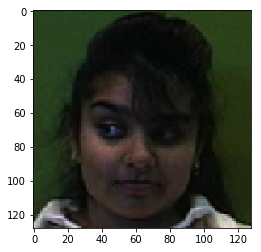

In [0]:
X_backup = X
print (len(X_backup))
plt.imshow(load_image(X[3000]), interpolation='nearest')
plt.show()

In [0]:
test = load_image(dataset_path + "male/gjnorm/gjnorm.6.jpg")
print("Test Shape = {}".format(str(test.shape)))

Test Shape = (128, 128, 3)


In [0]:
'''
  Making Minibatches
'''
BUFFER_SIZE = 2944
BATCH_SIZE = 32

print("Number Of Batches = {}".format(BUFFER_SIZE//BATCH_SIZE))

Number Of Batches = 92


In [0]:
train_data = np.array(X)
np.random.shuffle(train_data)
print(len(train_data[:BUFFER_SIZE]))

train_data = np.split(train_data[:BUFFER_SIZE], BUFFER_SIZE//BATCH_SIZE)

print("Number of Bactches = {}".format(len(train_data)))
print("Batch Size = {}".format(len(train_data[0])))

2944
Number of Bactches = 92
Batch Size = 32


In [0]:
def make_generator_model():
  """
    Implements the forward propagation for the model:
      CONV2D -> NORM -> RELU -> CONV2D -> NORM -> RELU -> CONV2D -> NORM -> RELU -> CONV2D -> NORM -> RELU -> CONV2D -> NORM -> RELU -> CONV2D -> NORM -> RELU
      -> CONV2D -> NORM -> RELU -> CONV2D -> NORM -> RELU -> CONV2D -> NORM -> RELU -> CONV2D -> NORM -> RELU -> CONV2D -> NORM -> RELU

    
    Arguments:
      None

    Returns:
      Generator Model
  """
  model = tf.keras.Sequential()
  
  model = tf.keras.Sequential()

  # Encoder Layers
  model.add(layers.Conv2D(8, (5, 5), strides=2, padding='same', input_shape=(128, 128, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  
  model.add(layers.Conv2D(16, (5, 5), strides=2, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  
  model.add(layers.Conv2D(32, (5, 5), strides=2, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  
  model.add(layers.Conv2D(64, (5, 5), strides=2, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  
  model.add(layers.Conv2D(100, (4, 4), strides=2, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  
  model.add(layers.Conv2DTranspose(64, (4, 4), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  
  model.add(layers.Conv2DTranspose(32, (6, 6), strides=2, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  
  model.add(layers.Conv2DTranspose(16, (6, 6), strides=2, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  
  model.add(layers.Conv2DTranspose(8, (7, 7), strides=2, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  
  model.add(layers.Conv2DTranspose(8, (7, 7), strides=2, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  
  model.add(layers.Conv2DTranspose(3, (8, 8), strides=2, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  
  return model

In [0]:
generator = make_generator_model()

In [0]:
def make_discriminator_model():
    """
      Implements the discriminator propagation for the model:
        SEQUENTIAL -> CONV2D -> RELU -> DROPOUT -> CONV2D -> RELU -> DROPOUT -> CONV2D -> RELU -> DROPOUT -> FLATTEN -> DENSE

      Arguments:
        None

      Returns:
        Discriminator Model
    """
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3)) 
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

     
    return model

In [0]:
discriminator = make_discriminator_model()

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [0]:
def discriminator_loss(real_output, fake_output):
  """
    Return Discriminator Loss
    
    Arguments:
      real_output - Real Output
      fake_output - Fake Output

    Returns:
      Discriminator Loss
  """
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [0]:
def generator_loss(fake_output):
  """
    Return Generator Loss
    
    Arguments:
      fake_output - Fake Output

    Returns:
      Generator Loss
  """
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 8

seed = tf.random.normal([num_examples_to_generate, 128, 128, 3])



In [0]:
def load_image( infilename ) :
    img = PIL.Image.open( infilename )
    img = img.resize((128, 128))
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

In [0]:
def train_step(images):
    """
      The training loop begins with generator receiving a random seed as input. 
      That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). 
      The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.
      
      Args:
        Images
      
      Output:
        Generator Loss, Discriminator Loss
    """
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    new_images = []
    i = 0 
    for file_name in images:
        i+=1
        new_pic = load_image(file_name)
        new_images.append(new_pic)
    images = np.array(new_images)
    images = images.reshape(images.shape[0], 128, 128, 3).astype('float32')
    images = (images - 127.5)/127.5
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(images, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # The zip() function returns an iterator of tuples based on the iterable object.
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    images = None
    
    return gen_loss, disc_loss

In [0]:
generator_loss_epoch = []
discriminator_loss_epoch = []

In [0]:
"""
  Checkpoint directory
"""
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [0]:
def train(dataset, epochs, X_data):  
  """
    Training of Model
  """
  for epoch in range(epochs):
    start = time.time()
    batch_no = 1
    for image_batch in dataset:
      batch_no += 1
      g_loss, d_loss = train_step(image_batch)
      
    generator_loss_epoch.append(g_loss)
    discriminator_loss_epoch.append(d_loss)
    
    print("Epoch = {}".format(epoch+1))
    print("\tGenerator Loss = {}".format(g_loss))
    print("\tDiscriminator Loss = {}".format(d_loss))

    generate_and_save_images(generator,
                             epoch + 1,
                             np.array(X_data))
    
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    
  generate_and_save_images(generator, epochs, np.array(X_data))

In [0]:
def generate_and_save_images(model, epoch, test_input):
  print(test_input.shape)
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))
#   for i in range(predictions.shape[0]):
#       plt.subplot(8, 8, i+1)
#       plt.imshow(predictions[i])
#       plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:

X_data = []
for i in range(num_examples_to_generate):
    image = load_image(X[i])
    X_data.append(image.astype('float32'))

print('X_data shape:', np.array(X_data).shape, seed.shape)

X_data shape: (8, 128, 128, 3) (8, 128, 128, 3)


In [87]:
%%time
train(train_data, 50, X_data)

Epoch = 1
	Generator Loss = 7.635019302368164
	Discriminator Loss = 0.0007488125120289624
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 2
	Generator Loss = 8.257295608520508
	Discriminator Loss = 0.00029488722793757915
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 3
	Generator Loss = 8.826700210571289
	Discriminator Loss = 0.00015606253873556852
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 4
	Generator Loss = 8.643171310424805
	Discriminator Loss = 0.00023137776588555425
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 5
	Generator Loss = 9.542734146118164
	Discriminator Loss = 8.79541112226434e-05
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 6
	Generator Loss = 9.81679916381836
	Discriminator Loss = 6.002172449370846e-05
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 7
	Generator Loss = 10.340239524841309
	Discriminator Loss = 3.546573134372011e-05
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 8
	Generator Loss = 10.390935897827148
	Discriminator Loss = 3.17620397254359e-05
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 9
	Generator Loss = 11.117086410522461
	Discriminator Loss = 1.6626136130071245e-05
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 10
	Generator Loss = 11.38064193725586
	Discriminator Loss = 1.2844967386627104e-05
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 11
	Generator Loss = 11.393350601196289
	Discriminator Loss = 1.1621144039963838e-05
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 12
	Generator Loss = 11.603572845458984
	Discriminator Loss = 9.589811270416249e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 13
	Generator Loss = 11.73791217803955
	Discriminator Loss = 8.643504770589061e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 14
	Generator Loss = 11.726004600524902
	Discriminator Loss = 8.628140676592011e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 15
	Generator Loss = 11.839795112609863
	Discriminator Loss = 7.972981620696373e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 16
	Generator Loss = 11.884471893310547
	Discriminator Loss = 7.068313607305754e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 17
	Generator Loss = 12.009565353393555
	Discriminator Loss = 6.214380391611485e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 18
	Generator Loss = 12.223175048828125
	Discriminator Loss = 5.435247658169828e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 19
	Generator Loss = 12.38789176940918
	Discriminator Loss = 4.480751158553176e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 20
	Generator Loss = 12.49049186706543
	Discriminator Loss = 3.878175903082592e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 21
	Generator Loss = 12.642077445983887
	Discriminator Loss = 3.3217897907888982e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 22
	Generator Loss = 12.76510238647461
	Discriminator Loss = 2.9184436698415084e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 23
	Generator Loss = 12.768129348754883
	Discriminator Loss = 2.8965650926693343e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 24
	Generator Loss = 12.897903442382812
	Discriminator Loss = 2.541009962442331e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 25
	Generator Loss = 13.025996208190918
	Discriminator Loss = 2.358915935474215e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 26
	Generator Loss = 13.056517601013184
	Discriminator Loss = 2.166168087569531e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 27
	Generator Loss = 13.178962707519531
	Discriminator Loss = 1.9439619336480973e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 28
	Generator Loss = 13.255749702453613
	Discriminator Loss = 1.8425051848680596e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 29
	Generator Loss = 13.231969833374023
	Discriminator Loss = 1.8102708736478235e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 30
	Generator Loss = 13.328140258789062
	Discriminator Loss = 1.647947215133172e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 31
	Generator Loss = 13.424116134643555
	Discriminator Loss = 1.501927954450366e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 32
	Generator Loss = 13.529903411865234
	Discriminator Loss = 1.3458901548801805e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 33
	Generator Loss = 13.534627914428711
	Discriminator Loss = 1.509977209934732e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 34
	Generator Loss = 13.664226531982422
	Discriminator Loss = 1.194056153508427e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 35
	Generator Loss = 13.79885482788086
	Discriminator Loss = 1.0351845958211925e-06
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 36
	Generator Loss = 13.900708198547363
	Discriminator Loss = 9.359986279378063e-07
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 37
	Generator Loss = 13.938102722167969
	Discriminator Loss = 8.945614808908431e-07
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 38
	Generator Loss = 13.952432632446289
	Discriminator Loss = 8.797613872957299e-07
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 39
	Generator Loss = 14.110974311828613
	Discriminator Loss = 7.507969144171511e-07
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 40
	Generator Loss = 14.171906471252441
	Discriminator Loss = 7.161143003031611e-07
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 41
	Generator Loss = 14.205732345581055
	Discriminator Loss = 6.843258688604692e-07
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 42
	Generator Loss = 14.246938705444336
	Discriminator Loss = 6.598817776648502e-07
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 43
	Generator Loss = 14.369861602783203
	Discriminator Loss = 5.82578138619283e-07
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 44
	Generator Loss = 14.407817840576172
	Discriminator Loss = 5.605675710285141e-07
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 45
	Generator Loss = 14.445014953613281
	Discriminator Loss = 5.382528911468398e-07
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 46
	Generator Loss = 14.550167083740234
	Discriminator Loss = 4.872916861131671e-07
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 47
	Generator Loss = 14.584741592407227
	Discriminator Loss = 4.821988568437519e-07
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 48
	Generator Loss = 14.604927062988281
	Discriminator Loss = 4.851752350987226e-07
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 49
	Generator Loss = 14.743616104125977
	Discriminator Loss = 4.0483672592017683e-07
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

Epoch = 50
	Generator Loss = 14.809732437133789
	Discriminator Loss = 3.766575673580519e-07
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>

CPU times: user 17min 23s, sys: 2min 29s, total: 19min 53s
Wall time: 26min 40s


In [88]:

X_data = []
for i in range(num_examples_to_generate):
    image = load_image(X[i])
    X_data.append(image.astype('float32'))

print('X_data shape:', np.array(X_data).shape, seed.shape)
generate_and_save_images(generator,
                           50,
                           np.array(X_data))

X_data shape: (8, 128, 128, 3) (8, 128, 128, 3)
(8, 128, 128, 3)


<Figure size 288x288 with 0 Axes>